<a href="https://colab.research.google.com/github/qerty2006/test/blob/master/LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Main version


In [9]:
#@title Libraries
import heapq
import random
import numpy as np
from datetime import datetime, timedelta, timezone

# --- Install & Import Hugging Face Libraries ---
!pip install -q transformers torch accelerate
import torch
from transformers import pipeline

# --- File Management ---
import json
import re
from collections import defaultdict

# --- Plotting ---
import networkx as nx
import matplotlib.pyplot as plt

# --- Conformity ---
!pip install -q faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.0 MB/s eta 0:00:00


In [ ]:
#@title Agent Definitions

import json

AGENT_DEFINITIONS_CONTENT = {
  "agents": {
    "Alice": {
      "persona": {
        "role": "Software Engineer",
        "linguistic_style": "direct and technical",
        "block": 1
      },
      "propensities": {
        "reply_prob": 0.7,
        "mention_prob": 0.3,
        "initiation_prob": 0.8,
        "latency_model": ["lognormal", 1.5, 0.4],
        "verbosity_model": ["poisson", 30]
      }
    },
    "Bob": {
      "persona": {
        "role": "Product Manager",
        "linguistic_style": "strategic and user-focused",
        "block": 1
      },
      "propensities": {
        "reply_prob": 0.6,
        "mention_prob": 0.4,
        "initiation_prob": 0.6,
        "latency_model": ["lognormal", 1.8, 0.6],
        "verbosity_model": ["poisson", 25]
      }
    },
    "Charlie": {
      "persona": {
        "role": "UX Designer",
        "linguistic_style": "empathetic and visual",
        "block": 0
      },
      "propensities": {
        "reply_prob": 0.5,
        "mention_prob": 0.2,
        "initiation_prob": 0.4,
        "latency_model": ["lognormal", 2.0, 0.7],
        "verbosity_model": ["poisson", 20]
      }
    },
    "Diana": {
      "persona": {
        "role": "QA Engineer",
        "linguistic_style": "detailed and critical",
        "block": 1
      },
      "propensities": {
        "reply_prob": 0.6,
        "mention_prob": 0.3,
        "initiation_prob": 0.5,
        "latency_model": ["lognormal", 1.7, 0.5],
        "verbosity_model": ["poisson", 28]
      }
    },
    "Eva": {
      "persona": {
        "role": "Project Coordinator",
        "linguistic_style": "organized and encouraging",
        "block": 0
      },
      "propensities": {
        "reply_prob": 0.65,
        "mention_prob": 0.35,
        "initiation_prob": 0.7,
        "latency_model": ["lognormal", 1.6, 0.5],
        "verbosity_model": ["poisson", 27]
      }
    },
    "Frank": {
      "persona": {
        "role": "Financial Analyst",
        "linguistic_style": "concise and data-driven",
        "block": 1
      },
      "propensities": {
        "reply_prob": 0.55,
        "mention_prob": 0.25,
        "initiation_prob": 0.5,
        "latency_model": ["lognormal", 1.9, 0.6],
        "verbosity_model": ["poisson", 22]
      }
    },
    "George": {
      "persona": {
        "role": "Technical Lead",
        "linguistic_style": "problem-solving and direct",
        "block": 0
      },
      "propensities": {
        "reply_prob": 0.75,
        "mention_prob": 0.4,
        "initiation_prob": 0.85,
        "latency_model": ["lognormal", 1.4, 0.3],
        "verbosity_model": ["poisson", 32]
      }
    }
  },
  "affinity_matrix": [
    [0.9, .1],
    [0.1, 0.9]
  ]
}

with open('agents.json', 'w', encoding='utf-8') as f:
    json.dump(AGENT_DEFINITIONS_CONTENT, f, indent=2, ensure_ascii=False)
print("Created agents.json")

Created agents.json


In [ ]:
#@title Topic Definitions

import json

TOPICS_CONTENT = [
  "Project Alpha next steps",
  "frontend framework discussion",
  "user feedback analysis",
  "upcoming team social event",
  "backend API design review"
]



with open('topics.json', 'w', encoding='utf-8') as f:
    json.dump(TOPICS_CONTENT, f, indent=2, ensure_ascii=False)
print("Created topics.json")

Created topics.json


In [13]:
#@title Content Generation Workflow
# --- Part 1: The Content Generation Engine ---

class RealLLMContentEngine:
    """
    This class is a wrapper for Hugging Face transformers. It uses a local LLM
    to generate chat message content directly within the notebook environment.
    """
    def __init__(self, model_name='Qwen/Qwen2.5-1.5B-Instruct'):
        self.model_name = model_name
        print(f"Initializing HF Content Engine with model: {self.model_name}")
        try:
            # Initialize the text-generation pipeline
            # We pass torch_dtype="auto" directly to use the optimal precision (e.g. bfloat16)
            self.pipe = pipeline(
                "text-generation",
                model=self.model_name,
                torch_dtype="auto",
                device_map="auto"
            )
            print(f"Model '{self.model_name}' loaded successfully.")
        except Exception as e:
            print(f"Error loading model {self.model_name}: {e}")
            raise

    def generate(self, agent_persona, context):
        """
        Builds a detailed prompt and sends it to the local HF LLM pipeline.
        """
        messages = []

        # Step 1: Create the System Prompt.
        system_prompt = f"""You are a chat participant named {agent_persona['user_id']}.
          Your role is: {agent_persona['role']}.
          Your linguistic style is: {agent_persona['linguistic_style']}.
          You are in a group chat. You must generate ONLY the chat message content.
          Do NOT output your own name, headers, or any other text.
          Do NOT repeat the prompt. Just generate the message.
          """
        messages.append({'role': 'system', 'content': system_prompt})

        # Step 2: Add the recent chat history to the prompt.
        chat_history = context.get("chat_history", [])
        for msg in chat_history:
            role = "assistant" if msg['sender'] == agent_persona['user_id'] else "user"
            if role == 'user':
                content = f"{msg['sender']}: {msg['content']}"
            else:
                content = msg['content']
            messages.append({'role': role, 'content': content})

        # Step 3: Create the final Task Prompt.
        mode = context.get("interaction_mode", "broadcast")
        topic = context.get("current_topic", "a general topic")
        target_user = context.get("target_user")
        target_length = context.get("target_length", 25)

        task = f"It is now your turn to speak. "
        if mode == "broadcast":
            task += f"Start a new conversation thread about: {topic}."
        elif mode == "reply":
            task += f"You are replying to {target_user} about: {topic}."
        elif mode == "mention":
            task += f"You need to @mention {target_user} regarding: {topic}."

        task += f" Keep your response to about {target_length} words."
        messages.append({'role': 'user', 'content': task})

        # Step 4: Call the Hugging Face Pipeline.
        try:
            outputs = self.pipe(
                messages,
                max_new_tokens=int(target_length * 4),
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
            )

            generated_response = outputs[0]['generated_text'][-1]['content']
            return generated_response.strip().replace('"', '')

        except Exception as e:
            print(f"!! ERROR generating content from HF: {e}")
            return "[LLM Error: Could not generate response]"

# --- Part 2: The Agent-Based Model (ABM) ---

class Agent:
    """
    Represents a single simulated user in the chat.
    """
    def __init__(self, user_id, persona, propensities):
        self.user_id = user_id
        self.persona = persona
        self.persona['user_id'] = user_id
        self.propensities = propensities
        self.state = {"current_goal": "participate"}

    def decides_to_act(self, message, affinity_score):
        prob = self.propensities.get("reply_prob", 0.1) * affinity_score
        return random.random() < prob

    def sample_latency(self):
        model_params = self.propensities.get("latency_model", ("lognormal", 2.0, 0.5))
        model_type = model_params[0]

        if model_type == "lognormal":
            mu, sigma = model_params[1], model_params[2]
            return max(0.5, np.random.lognormal(mean=mu, sigma=sigma))
        return random.uniform(5, 60)

    def sample_verbosity(self):
        model_params = self.propensities.get("verbosity_model", ("poisson", 20))
        model_type = model_params[0]

        if model_type == "poisson":
            lam = model_params[1]
            return max(5, np.random.poisson(lam=lam))
        return random.randint(10, 30)

    def get_affinity_for_block(self, target_block_index):
        return self.propensities.get("affinity_row")[target_block_index]

class SimulationOrchestrator:
    """
    Manages the agents, time, and events.
    """
    def __init__(self, agents, affinity_matrix, topics, llm_engine, start_time):
        self.agents = {agent.user_id: agent for agent in agents}
        self.agent_list = list(agents)
        self.affinity_matrix = affinity_matrix
        self.topics = topics
        self.llm = llm_engine
        self.current_time = start_time
        self.event_queue = []
        self.event_counter = 0
        self.message_log = []
        self.history = []
        self.user_to_block = {
            agent.user_id: agent.persona.get("block", 0)
            for agent in agents
        }

    def schedule_event(self, timestamp, agent_id, event_type, context=None):
        self.event_counter += 1
        event = (timestamp, self.event_counter, agent_id, event_type, context or {})
        heapq.heappush(self.event_queue, event)

    def build_prompt_context(self, agent, **kwargs):
        context = {
            "interaction_mode": "broadcast",
            "current_topic": random.choice(self.topics),
            "target_user": None,
            "target_length": agent.sample_verbosity(),
            "chat_history": self.history,
        }
        context.update(kwargs)
        return context

    def run(self, max_events=50):
        print(f"--- Starting simulation at {self.current_time} ---")
        initiator = max(
            self.agent_list,
            key=lambda a: a.propensities.get("initiation_prob", 0.1)
        )
        self.schedule_event(self.current_time, initiator.user_id, "START_SESSION")

        events_processed = 0
        while self.event_queue and events_processed < max_events:
            timestamp, _, agent_id, event_type, context = heapq.heappop(self.event_queue)

            if timestamp < self.current_time:
                continue
            self.current_time = timestamp

            agent = self.agents[agent_id]
            self.handle_event(agent, event_type, context)
            events_processed += 1

        print(f"--- Simulation finished after {events_processed} events ---")
        return self.message_log

    def handle_event(self, agent, event_type, context):
        new_message = None

        if event_type == "START_SESSION":
            prompt_context = self.build_prompt_context(agent, interaction_mode="broadcast")
            message_content = self.llm.generate(agent.persona, prompt_context)
            new_message = self.log_message(agent, message_content, prompt_context)

            session_rate_per_hour = 0.5
            hours_to_next_session = np.random.exponential(1.0 / session_rate_per_hour)
            next_session_time = self.current_time + timedelta(hours=hours_to_next_session)

            initiator = random.choices(
                self.agent_list,
                weights=[a.propensities.get("initiation_prob", 0.1) for a in self.agent_list],
                k=1
            )[0]
            self.schedule_event(next_session_time, initiator.user_id, "START_SESSION")

        elif event_type == "GENERATE_REPLY":
            target_user = context.get("target_user")
            mode = "reply"
            if random.random() < agent.propensities.get("mention_prob", 0.1):
                agent_block = self.user_to_block[agent.user_id]
                affinity_row = self.affinity_matrix[agent_block]
                target_block = random.choices(range(len(affinity_row)), weights=affinity_row, k=1)[0]
                possible_targets = [
                    a.user_id for a in self.agent_list
                    if self.user_to_block[a.user_id] == target_block and a.user_id!= agent.user_id
                ]
                if possible_targets:
                    target_user = random.choice(possible_targets)
                    mode = "mention"

            prompt_context = self.build_prompt_context(
                agent,
                interaction_mode=mode,
                target_user=target_user,
                current_topic=context.get("topic", "that last point")
            )
            message_content = self.llm.generate(agent.persona, prompt_context)
            new_message = self.log_message(agent, message_content, prompt_context)

        if new_message:
            for other_agent in self.agent_list:
                if other_agent.user_id!= agent.user_id:
                    i_block = self.user_to_block[other_agent.user_id]
                    j_block = self.user_to_block[agent.user_id]
                    affinity = self.affinity_matrix[i_block][j_block]
                    if other_agent.decides_to_act(new_message, affinity):
                        latency_sec = other_agent.sample_latency()
                        reply_time = self.current_time + timedelta(seconds=latency_sec)
                        self.schedule_event(
                            reply_time,
                            other_agent.user_id,
                            "GENERATE_REPLY",
                            context={
                                "reply_to_msg_id": new_message["id"],
                                "target_user": agent.user_id,
                                "topic": prompt_context.get("current_topic", "unknown")
                            }
                        )

    def log_message(self, agent, content, prompt_context):
        msg_id = len(self.message_log)
        timestamp_str = self.current_time.isoformat()
        log_entry = [agent.user_id, timestamp_str, content]
        self.message_log.append(log_entry)
        new_message = {
            "id": msg_id,
            "sender": agent.user_id,
            "timestamp": timestamp_str,
            "content": content,
            "topic": prompt_context.get("current_topic", "unknown")
        }
        self.history.append(new_message)
        if len(self.history) > 10:
            self.history.pop(0)
        print(f"{timestamp_str} | {agent.user_id}: {content}")
        return new_message

# --- Part 3: Simulation Setup and Execution ---

def run_simulation(model_name='Qwen/Qwen2.5-1.5B-Instruct',
                   max_events=150,
                   output_filename="synthetic_chat_log.json",
                   topics = "topics.json",
                   agents = "agents.json",
                   seed = 42
                   ):

    # Set the random seed for reproducibility.
    random.seed(seed)

    # --- Step 1: Load Simulation Parameters from JSON ---
    print("--- Loading simulation parameters from JSON files ---")

    # Load TOPICS from topics.json
    with open(topics, 'r', encoding='utf-8') as f:
        TOPICS = json.load(f)

    # Load AGENT_DEFINITIONS and AFFINITY_MATRIX from agents.json
    with open(agents, 'r', encoding='utf-8') as f:
        agents_config = json.load(f)
        AGENT_DEFINITIONS = agents_config["agents"]
        AFFINITY_MATRIX = agents_config["affinity_matrix"]

    print("--- Simulation parameters loaded successfully ---")

    # --- Step 2: Initialize Simulation Objects ---

    # Create the Agent objects.
    agents = []
    for user_id, config in AGENT_DEFINITIONS.items():
        # Add the affinity row based on the agent's block
        config["propensities"]["affinity_row"] = AFFINITY_MATRIX[config["persona"]["block"]]
        agents.append(
            Agent(user_id, config["persona"], config["propensities"])
        )

    # Instantiate the HF LLM engine.
    llm = RealLLMContentEngine(model_name=model_name)

    # Set the simulation's starting time.
    start_time = datetime(2025, 11, 15, 12, 0, 0, tzinfo=timezone.utc)

    # Create the main orchestrator object that will run the simulation.
    simulation = SimulationOrchestrator(
        agents=agents,
        affinity_matrix=AFFINITY_MATRIX,
        topics=TOPICS,
        llm_engine=llm,
        start_time=start_time
    )

    # --- Step 3: Run the Simulation ---

    # Start the simulation and run it for a maximum of 150 events.
    synthetic_log = simulation.run(max_events=max_events)

    # --- Step 4: Save the Output ---

    # Convert the raw log into a more readable list of dictionaries.
    structured_log = [
        {"sender": entry[0], "timestamp": entry[1], "content": entry[2]}
        for entry in synthetic_log
    ]

    # Save the structured log to a JSON file
    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(structured_log, f, indent=2, ensure_ascii=False)

    print(f"\n--- Conversation log saved to {output_filename} ---")

    print("\n\n--- FINAL SYNTHETIC CHAT LOG (for console) ---")
    for entry in synthetic_log:
        print(entry)


if __name__ == "__main__":
    # Example of how to call the function
    run_simulation()


--- Loading simulation parameters from JSON files ---
--- Simulation parameters loaded successfully ---
Initializing HF Content Engine with model: Qwen/Qwen2.5-1.5B-Instruct


Device set to use cuda:0


Model 'Qwen/Qwen2.5-1.5B-Instruct' loaded successfully.
--- Starting simulation at 2025-11-15 12:00:00+00:00 ---
2025-11-15T12:00:00+00:00 | George: Project Alpha will prioritize sprint planning for the next two weeks. We'll discuss scope and timeline adjustments as needed.
2025-11-15T12:56:39.702004+00:00 | Alice: Alice: The team's upcoming social event will be an all-hands meeting on Wednesday evening at 7 PM in our conference room. RSVPs due by Tuesday noon.
2025-11-15T12:56:42.021380+00:00 | Bob: Bob: Sounds like fun! Looking forward to it. Don't forget to confirm attendance.
2025-11-15T12:56:45.732208+00:00 | Diana: @Bob - Looking forward to our all-hands meeting on Wednesday evening starting at 7 PM in the conference room. Please RSVP by Tuesday noon.
2025-11-15T12:56:47.201055+00:00 | Alice: Alice: Thanks, Diana! I've confirmed my attendance. Let's make sure everyone else does too.
2025-11-15T12:56:49.543041+00:00 | Frank: @Bob - RSVP required by Tuesday noon for our all-hands m

In [14]:
# @title Interaction Weights
# Load the chat log
with open('synthetic_chat_log.json', 'r') as f:
    chat_log = json.load(f)

# Initialize a dictionary to store interaction weights
interaction_weights = defaultdict(int)

last_speaker = None

# Iterate through the messages in chronological order
for message in chat_log:
    sender = message['sender']
    content = message['content']

    # Identify mentioned users using regex
    mentions = re.findall(r'@(\w+)', content)

    if mentions:
        # Strong weight for explicit mentions
        for mentioned_user in mentions:
            if mentioned_user != sender:  # Avoid self-interaction if strictly social graph
                interaction_weights[(sender, mentioned_user)] += 2
    else:
        # Weak weight for implicit reply to the last speaker
        if last_speaker and last_speaker != sender:
            interaction_weights[(sender, last_speaker)] += 1

    # Update last_speaker to be the current sender
    last_speaker = sender

# Print the resulting dictionary of edge weights
print("Interaction Weights:")
for pair, weight in interaction_weights.items():
    print(f"{pair}: {weight}")

Interaction Weights:
('Alice', 'George'): 2
('Bob', 'Alice'): 12
('Diana', 'Bob'): 13
('Alice', 'Diana'): 17
('Frank', 'Bob'): 8
('Alice', 'Frank'): 11
('Bob', 'Eva'): 4
('Alice', 'Bob'): 2
('Diana', 'Alice'): 10
('Frank', 'Diana'): 6
('Diana', 'Frank'): 3
('Diana', 'George'): 4
('George', 'Alice'): 7
('Frank', 'Alice'): 12
('Frank', 'Charlie'): 3
('Bob', 'Frank'): 8
('Bob', 'Diana'): 8
('Eva', 'Frank'): 2
('Frank', 'Eva'): 2
('Diana', 'Charlie'): 3
('Charlie', 'Eva'): 3
('Alice', 'Charlie'): 2
('Eva', 'Alice'): 3
('Eva', 'George'): 4
('Alice', 'Eva'): 4
('George', 'Bob'): 6
('George', 'Frank'): 2
('Bob', 'George'): 2
('George', 'Diana'): 2
('Eva', 'Bob'): 2
('Charlie', 'George'): 6
('Bob', 'Charlie'): 1
('George', 'Eva'): 3
('Charlie', 'Frank'): 1
('Eva', 'Diana'): 2
('Diana', 'Eva'): 1
('George', 'Charlie'): 2
('Charlie', 'Diana'): 1


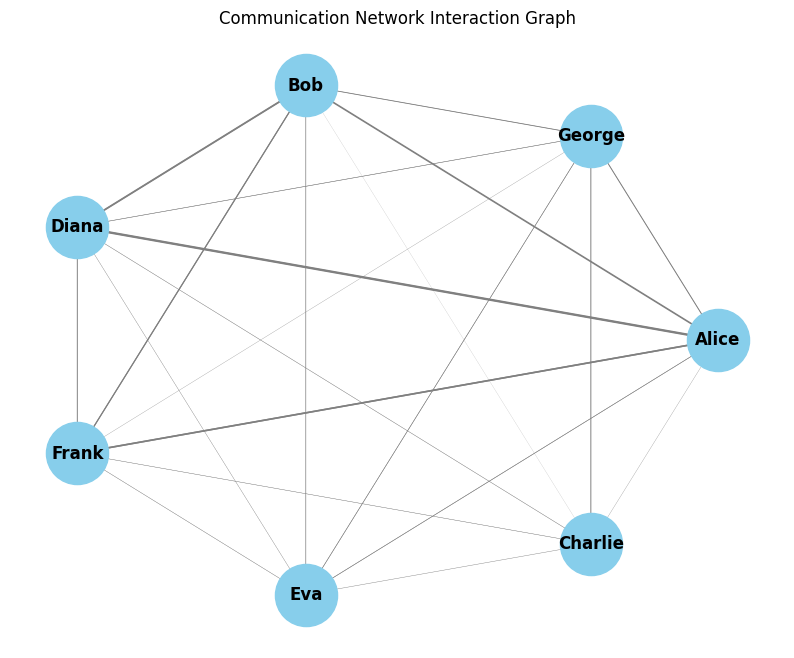

In [15]:
# @title Graph

# Initialize a directed graph
G = nx.DiGraph()

# Add edges with weights
for (u, v), weight in interaction_weights.items():
    G.add_edge(u, v, weight=weight)

# Determine layout
pos = nx.circular_layout(G)

# Create a list of edge widths derived from the edge weights
# Scaling factor to adjust thickness
weights = [G[u][v]['weight'] for u, v in G.edges()]
width = [w * 0.1 for w in weights]

# Visualize the graph
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=width, arrowstyle='->', arrowsize=20, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.title('Communication Network Interaction Graph')
plt.axis('off')
plt.show()

In [16]:
import json
import uuid
import os
from datetime import datetime, timedelta
from typing import List, Dict, Optional

# --- Configuration & Schema Simulation ---

class DataGenerator:
    def __init__(self):
        self.users_map = {}  # Map "username" -> User Object
        self.projects_map = {} # Map "project_name" -> Project Object
        self.messages = []

    def generate_cuid(self) -> str:
        """
        Generates a CUID-like string.
        Prisma CUIDs are 25 chars starting with 'c'.
        Using UUID here is often compatible, but we'll mimic a short ID.
        """
        return 'c' + uuid.uuid4().hex[:24]

    def get_or_create_user(self, username: str) -> Dict:
        """
        Ensures a user exists for the given username.
        Generates required fields from schema.prisma:
        - id, email, username, firstName, lastName, role, etc.
        """
        if username in self.users_map:
            return self.users_map[username]

        # Synthetic user data generation
        user_id = self.generate_cuid()

        # Handle simple name extraction
        parts = username.split(" ")
        first_name = parts[0]
        last_name = parts[1] if len(parts) > 1 else "User"

        email = f"{username.lower().replace(' ', '.')}@example.com"

        user = {
            "id": user_id,
            "username": username,
            "email": email,
            "firstName": first_name,
            "lastName": last_name,
            "isBot": False,
            "role": "USER",
            "createdAt": datetime.now().isoformat(),
            "updatedAt": datetime.now().isoformat(),
            # Default empty values for nullable fields to ensure schema compliance
            "authProviderId": None,
            "interests": None,
            "botMetadata": None,
            "consentedToVersion": None
        }

        self.users_map[username] = user
        return user

    def get_or_create_project(self, project_name: str, owner_id: str) -> Dict:
        """
        Creates a project context for the chat.
        """
        if project_name in self.projects_map:
            return self.projects_map[project_name]

        project_id = self.generate_cuid()

        project = {
            "id": project_id,
            "name": project_name,
            "description": f"Synthetic project context for {project_name}",
            "createdAt": datetime.now().isoformat(),
            "updatedAt": datetime.now().isoformat(),
            "ownerId": owner_id, # Linking to a valid user is crucial
            "isArchived": False
        }

        self.projects_map[project_name] = project
        return project

    def process_conversation(self, raw_messages: List[Dict[str, str]], project_name: str = "General Chat") -> None:
        """
        Main logic to process a list of raw messages.
        Expected raw_messages format: [{'sender': 'Alice', 'content': 'Hello', 'timestamp': '...'}]
        """

        # 1. Ensure at least one user exists to own the project
        if not raw_messages:
            return

        first_sender_name = raw_messages[0].get("sender", "System")
        project_owner = self.get_or_create_user(first_sender_name)

        # 2. Get/Create Project
        project = self.get_or_create_project(project_name, project_owner['id'])

        # 3. Process Messages
        # Fallback time calculation if 'timestamp' is missing in JSON
        fallback_base_time = datetime.now() - timedelta(minutes=len(raw_messages))

        for index, msg in enumerate(raw_messages):
            sender_name = msg.get("sender", "Unknown")
            content = msg.get("content", "")

            # Use provided timestamp if available, else calculate one
            provided_timestamp = msg.get("timestamp")
            if provided_timestamp:
                created_at = provided_timestamp
            else:
                created_at = (fallback_base_time + timedelta(minutes=index)).isoformat()

            # Ensure sender exists
            sender = self.get_or_create_user(sender_name)

            # Create Schema-Compliant Message
            chat_message = {
                "id": self.generate_cuid(),
                "content": content,
                "senderId": sender['id'],
                "projectId": project['id'],
                "createdAt": created_at,
                # Assuming standard Prisma fields if not explicitly in snippet
            }

            self.messages.append(chat_message)

    def export_data(self) -> Dict:
        return {
            "users": list(self.users_map.values()),
            "projects": list(self.projects_map.values()),
            "chatMessages": self.messages
        }

# --- Execution ---

if __name__ == "__main__":
    adapter = DataGenerator()
    input_filename = "synthetic_chat_log.json"
    output_filename = "seeded_chat_data.json"

    # 1. Load Data
    if os.path.exists(input_filename):
        print(f"Loading data from {input_filename}...")
        try:
            with open(input_filename, "r") as f:
                raw_data = json.load(f)
        except json.JSONDecodeError:
            print("Error: JSON file is invalid. Falling back to simulation.")
            raw_data = []
    else:
        print(f"File {input_filename} not found. Using built-in simulation data.")
        raw_data = [
            {"sender": "Alice", "content": "Hey Bob, did you see the new architecture?"},
            {"sender": "Bob", "content": "Yes Alice! It looks robust.", "timestamp": datetime.now().isoformat()},
        ]

    # 2. Process Data
    # You can change the project name here to group these messages under a specific project
    adapter.process_conversation(raw_data, project_name="Frontend Framework Discussion")

    # 3. Export Structured Data
    structured_data = adapter.export_data()

    # 4. Save to JSON
    with open(output_filename, "w") as f:
        json.dump(structured_data, f, indent=2)

    print(f"\nSuccessfully generated '{output_filename}':")
    print(f"- {len(structured_data['users'])} Users Created")
    print(f"- {len(structured_data['projects'])} Projects Created")
    print(f"- {len(structured_data['chatMessages'])} Messages Processed")

Loading data from synthetic_chat_log.json...

Successfully generated 'seeded_chat_data.json':
- 7 Users Created
- 1 Projects Created
- 150 Messages Processed


#Assymetric chat

In [ ]:
import json

AGENT_DEFINITIONS_CONTENT = {
  "agents": {
    "Alice": {
      "persona": {
        "role": "Software Engineer",
        "linguistic_style": "direct and technical",
        "block": 0
      },
      "propensities": {
        "reply_prob": 0.7,
        "mention_prob": 0.3,
        "initiation_prob": 0.8,
        "latency_model": ["lognormal", 1.5, 0.4],
        "verbosity_model": ["poisson", 30]
      }
    },
    "Bob": {
      "persona": {
        "role": "Product Manager",
        "linguistic_style": "strategic and user-focused",
        "block": 1
      },
      "propensities": {
        "reply_prob": 0.6,
        "mention_prob": 0.4,
        "initiation_prob": 0.6,
        "latency_model": ["lognormal", 1.8, 0.6],
        "verbosity_model": ["poisson", 25]
      }
    },
    "Charlie": {
      "persona": {
        "role": "UX Designer",
        "linguistic_style": "empathetic and visual",
        "block": 2
      },
      "propensities": {
        "reply_prob": 0.5,
        "mention_prob": 0.2,
        "initiation_prob": 0.4,
        "latency_model": ["lognormal", 2.0, 0.7],
        "verbosity_model": ["poisson", 20]
      }
    },
    "Diana": {
      "persona": {
        "role": "QA Engineer",
        "linguistic_style": "detailed and critical",
        "block": 3
      },
      "propensities": {
        "reply_prob": 0.6,
        "mention_prob": 0.3,
        "initiation_prob": 0.5,
        "latency_model": ["lognormal", 1.7, 0.5],
        "verbosity_model": ["poisson", 28]
      }
    }
  },
  "affinity_matrix": [
    [0.9, 0.9, 0.9, 0.9],
    [0.9, 0, 0, 0],
    [0.9, 0, 0, 0.9],
    [0.9, 0.9, 0, 0]
  ]
}

with open('agents.json', 'w', encoding='utf-8') as f:
    json.dump(AGENT_DEFINITIONS_CONTENT, f, indent=2, ensure_ascii=False)
print("Updated agents.json")



In [ ]:
import json

TOPICS_CONTENT = [
 "Do we need to buy bananas?"
]

with open('topics.json', 'w', encoding='utf-8') as f:
    json.dump(TOPICS_CONTENT, f, indent=2, ensure_ascii=False)
print("Updated topics.json")

In [ ]:
import heapq
import random
import numpy as np
from datetime import datetime, timedelta, timezone
import json

# --- Install & Import Hugging Face Libraries ---
!pip install -q transformers torch accelerate
import torch
from transformers import pipeline

# --- Part 1: The Content Generation Engine ---

class RealLLMContentEngine:
    """
    This class is a wrapper for Hugging Face transformers. It uses a local LLM
    to generate chat message content directly within the notebook environment.
    """
    def __init__(self, model_name='Qwen/Qwen2.5-1.5B-Instruct'):
        self.model_name = model_name
        print(f"Initializing HF Content Engine with model: {self.model_name}")
        try:
            # Initialize the text-generation pipeline
            # We pass torch_dtype="auto" directly to use the optimal precision (e.g. bfloat16)
            self.pipe = pipeline(
                "text-generation",
                model=self.model_name,
                torch_dtype="auto",
                device_map="auto"
            )
            print(f"Model '{self.model_name}' loaded successfully.")
        except Exception as e:
            print(f"!! ERROR loading model {self.model_name}: {e}")
            # Re-raise the exception to indicate a critical failure
            raise

    def generate(self, agent_persona, context):
        """
        Builds a detailed prompt and sends it to the local HF LLM pipeline.
        """
        messages = []

        # Step 1: Create the System Prompt.
        system_prompt = f"""You are a chat participant named {agent_persona['user_id']}.
Your role is: {agent_persona['role']}.
Your linguistic style is: {agent_persona['linguistic_style']}.
You are in a group chat. You must generate ONLY the chat message content.
Do NOT output your own name, headers, or any other text.
Do NOT repeat the prompt. Just generate the message.
"""
        messages.append({'role': 'system', 'content': system_prompt})

        # Step 2: Add the recent chat history to the prompt.
        chat_history = context.get("chat_history", [])
        for msg in chat_history:
            role = "assistant" if msg['sender'] == agent_persona['user_id'] else "user"
            if role == 'user':
                content = f"{msg['sender']}: {msg['content']}"
            else:
                content = msg['content']
            messages.append({'role': role, 'content': content})

        # Step 3: Create the final Task Prompt.
        mode = context.get("interaction_mode", "broadcast")
        topic = context.get("current_topic", "a general topic")
        target_user = context.get("target_user")
        target_length = context.get("target_length", 25)

        task = f"It is now your turn to speak. "
        if mode == "broadcast":
            task += f"Start a new conversation thread about: {topic}."
        elif mode == "reply":
            task += f"You are replying to {target_user} about: {topic}."
        elif mode == "mention":
            task += f"You need to @mention {target_user} regarding: {topic}."

        task += f" Keep your response to about {target_length} words."
        messages.append({'role': 'user', 'content': task})

        # Step 4: Call the Hugging Face Pipeline.
        try:
            outputs = self.pipe(
                messages,
                max_new_tokens=int(target_length * 4),
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
            )

            generated_response = outputs[0]['generated_text'][-1]['content']
            return generated_response.strip().replace('"', '')

        except Exception as e:
            print(f"!! ERROR generating content from HF: {e}")
            return "[LLM Error: Could not generate response]"


# --- Part 2: The Agent-Based Model (ABM) ---

class Agent:
    """
    Represents a single simulated user in the chat.
    """
    def __init__(self, user_id, persona, propensities):
        self.user_id = user_id
        self.persona = persona
        self.persona['user_id'] = user_id
        self.propensities = propensities
        self.state = {"current_goal": "participate"}

    def decides_to_act(self, message, affinity_score):
        prob = self.propensities.get("reply_prob", 0.1) * affinity_score
        return random.random() < prob

    def sample_latency(self):
        model_params = self.propensities.get("latency_model", ("lognormal", 2.0, 0.5))
        model_type = model_params[0]

        if model_type == "lognormal":
            mu, sigma = model_params[1], model_params[2]
            return max(0.5, np.random.lognormal(mean=mu, sigma=sigma))
        return random.uniform(5, 60)

    def sample_verbosity(self):
        model_params = self.propensities.get("verbosity_model", ("poisson", 20))
        model_type = model_params[0]

        if model_type == "poisson":
            lam = model_params[1]
            return max(5, np.random.poisson(lam=lam))
        return random.randint(10, 30)

    def get_affinity_for_block(self, target_block_index):
        return self.propensities.get("affinity_row")[target_block_index]


class SimulationOrchestrator:
    """
    Manages the agents, time, and events.
    """
    def __init__(self, agents, affinity_matrix, topics, llm_engine, start_time):
        self.agents = {agent.user_id: agent for agent in agents}
        self.agent_list = list(agents)
        self.affinity_matrix = affinity_matrix
        self.topics = topics
        self.llm = llm_engine
        self.current_time = start_time
        self.event_queue = []
        self.event_counter = 0
        self.message_log = []
        self.history = []
        self.user_to_block = {
            agent.user_id: agent.persona.get("block", 0)
            for agent in agents
        }

    def schedule_event(self, timestamp, agent_id, event_type, context=None):
        self.event_counter += 1
        event = (timestamp, self.event_counter, agent_id, event_type, context or {})
        heapq.heappush(self.event_queue, event)

    def build_prompt_context(self, agent, **kwargs):
        context = {
            "interaction_mode": "broadcast",
            "current_topic": random.choice(self.topics),
            "target_user": None,
            "target_length": agent.sample_verbosity(),
            "chat_history": self.history,
        }
        context.update(kwargs)
        return context

    def run(self, max_events=50):
        print(f"--- Starting simulation at {self.current_time} ---")
        initiator = max(
            self.agent_list,
            key=lambda a: a.propensities.get("initiation_prob", 0.1)
        )
        self.schedule_event(self.current_time, initiator.user_id, "START_SESSION")

        events_processed = 0
        while self.event_queue and events_processed < max_events:
            timestamp, _, agent_id, event_type, context = heapq.heappop(self.event_queue)

            if timestamp < self.current_time:
                continue
            self.current_time = timestamp

            agent = self.agents[agent_id]
            self.handle_event(agent, event_type, context)
            events_processed += 1

        print(f"--- Simulation finished after {events_processed} events ---")
        return self.message_log

    def handle_event(self, agent, event_type, context):
        new_message = None

        if event_type == "START_SESSION":
            prompt_context = self.build_prompt_context(agent, interaction_mode="broadcast")
            message_content = self.llm.generate(agent.persona, prompt_context)
            new_message = self.log_message(agent, message_content, prompt_context)

            session_rate_per_hour = 0.5
            hours_to_next_session = np.random.exponential(1.0 / session_rate_per_hour)
            next_session_time = self.current_time + timedelta(hours=hours_to_next_session)

            initiator = random.choices(
                self.agent_list,
                weights=[a.propensities.get("initiation_prob", 0.1) for a in self.agent_list],
                k=1
            )[0]
            self.schedule_event(next_session_time, initiator.user_id, "START_SESSION")

        elif event_type == "GENERATE_REPLY":
            target_user = context.get("target_user")
            mode = "reply"
            if random.random() < agent.propensities.get("mention_prob", 0.1):
                agent_block = self.user_to_block[agent.user_id]
                affinity_row = self.affinity_matrix[agent_block]
                target_block = random.choices(range(len(affinity_row)), weights=affinity_row, k=1)[0]
                possible_targets = [
                    a.user_id for a in self.agent_list
                    if self.user_to_block[a.user_id] == target_block and a.user_id!= agent.user_id
                ]
                if possible_targets:
                    target_user = random.choice(possible_targets)
                    mode = "mention"

            prompt_context = self.build_prompt_context(
                agent,
                interaction_mode=mode,
                target_user=target_user,
                current_topic=context.get("topic", "that last point")
            )
            message_content = self.llm.generate(agent.persona, prompt_context)
            new_message = self.log_message(agent, message_content, prompt_context)

        if new_message:
            for other_agent in self.agent_list:
                if other_agent.user_id!= agent.user_id:
                    i_block = self.user_to_block[other_agent.user_id]
                    j_block = self.user_to_block[agent.user_id]
                    affinity = self.affinity_matrix[i_block][j_block]
                    if other_agent.decides_to_act(new_message, affinity):
                        latency_sec = other_agent.sample_latency()
                        reply_time = self.current_time + timedelta(seconds=latency_sec)
                        self.schedule_event(
                            reply_time,
                            other_agent.user_id,
                            "GENERATE_REPLY",
                            context={
                                "reply_to_msg_id": new_message["id"],
                                "target_user": agent.user_id,
                                "topic": prompt_context.get("current_topic", "unknown")
                            }
                        )

    def log_message(self, agent, content, prompt_context):
        msg_id = len(self.message_log)
        timestamp_str = self.current_time.isoformat()
        log_entry = [agent.user_id, timestamp_str, content]
        self.message_log.append(log_entry)
        new_message = {
            "id": msg_id,
            "sender": agent.user_id,
            "timestamp": timestamp_str,
            "content": content,
            "topic": prompt_context.get("current_topic", "unknown")
        }
        self.history.append(new_message)
        if len(self.history) > 10:
            self.history.pop(0)
        print(f"{timestamp_str} | {agent.user_id}: {content}")
        return new_message


# --- Part 3: Simulation Setup and Execution ---

if __name__ == "__main__":

    # --- Step 1: Load Simulation Parameters from JSON ---
    print("--- Loading simulation parameters from JSON files ---")

    # Load TOPICS from topics.json
    with open('topics.json', 'r', encoding='utf-8') as f:
        TOPICS = json.load(f)

    # Load AGENT_DEFINITIONS and AFFINITY_MATRIX from agents.json
    with open('agents.json', 'r', encoding='utf-8') as f:
        agents_config = json.load(f)
        AGENT_DEFINITIONS = agents_config["agents"]
        AFFINITY_MATRIX = agents_config["affinity_matrix"]

    print("--- Simulation parameters loaded successfully ---")

    # --- Step 2: Initialize Simulation Objects ---

    # Create the Agent objects.
    agents = []
    for user_id, config in AGENT_DEFINITIONS.items():
        # Add the affinity row based on the agent's block
        config["propensities"]["affinity_row"] = AFFINITY_MATRIX[config["persona"]["block"]]
        agents.append(
            Agent(user_id, config["persona"], config["propensities"])
        )

    # Instantiate the HF LLM engine.
    llm = RealLLMContentEngine(model_name='Qwen/Qwen2.5-1.5B-Instruct')

    # Set the simulation's starting time.
    start_time = datetime(2025, 11, 15, 12, 0, 0, tzinfo=timezone.utc)

    # Create the main orchestrator object that will run the simulation.
    simulation = SimulationOrchestrator(
        agents=agents,
        affinity_matrix=AFFINITY_MATRIX,
        topics=TOPICS,
        llm_engine=llm,
        start_time=start_time
    )

    # --- Step 3: Run the Simulation ---

    # Start the simulation and run it for a maximum of 150 events.
    synthetic_log = simulation.run(max_events=150)

    # --- Step 4: Save the Output ---

    # Convert the raw log into a more readable list of dictionaries.
    structured_log = [
        {"sender": entry[0], "timestamp": entry[1], "content": entry[2]}
        for entry in synthetic_log
    ]

    # Save the structured log to a JSON file
    output_filename = "synthetic_chat_log.json"
    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(structured_log, f, indent=2, ensure_ascii=False)

    print(f"\n--- Conversation log saved to {output_filename} ---")

    print("\n\n--- FINAL SYNTHETIC CHAT LOG (for console) ---")
    for entry in synthetic_log:
        print(entry)

In [ ]:
import json
import re
from collections import defaultdict

# Load the chat log
with open('synthetic_chat_log.json', 'r') as f:
    chat_log = json.load(f)

# Initialize a dictionary to store interaction weights
interaction_weights = defaultdict(int)

last_speaker = None

# Iterate through the messages in chronological order
for message in chat_log:
    sender = message['sender']
    content = message['content']

    # Identify mentioned users using regex
    mentions = re.findall(r'@(\w+)', content)

    if mentions:
        # Strong weight for explicit mentions
        for mentioned_user in mentions:
            if mentioned_user != sender:  # Avoid self-interaction if strictly social graph
                interaction_weights[(sender, mentioned_user)] += 2
    else:
        # Weak weight for implicit reply to the last speaker
        if last_speaker and last_speaker != sender:
            interaction_weights[(sender, last_speaker)] += 1

    # Update last_speaker to be the current sender
    last_speaker = sender

# Print the resulting dictionary of edge weights
print("Interaction Weights:")
for pair, weight in interaction_weights.items():
    print(f"{pair}: {weight}")

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a directed graph
G = nx.DiGraph()

# Add edges with weights
for (u, v), weight in interaction_weights.items():
    G.add_edge(u, v, weight=weight)

# Determine layout
pos = nx.circular_layout(G)

# Create a list of edge widths derived from the edge weights
# Scaling factor to adjust thickness
weights = [G[u][v]['weight'] for u, v in G.edges()]
width = [w * 0.1 for w in weights]

# Visualize the graph
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=width, arrowstyle='->', arrowsize=20, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.title('Communication Network Interaction Graph (Updated Affinity)')
plt.axis('off')
plt.show()